We will use MLB's linear weights for each batted ball outcome

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import numpy as np

In [3]:
Weights = {"Walk": .692, "HitByPitch": .723,
           "Single": .885, "Double": 1.258,
            "Triple": 1.593, "HomeRun": 2.053}

In [4]:
kcl_Directory = "/Users/noahlippman/Documents/GitHub/Kernelytics-Projects/kclData"
kcl_files = glob.glob(os.path.join(kcl_Directory, "*.csv"))
data = pd.read_csv(kcl_files[0])

for f in kcl_files[1:]:
    newGame = pd.read_csv(f)
    data = pd.concat([data,newGame], axis = 0)

In [5]:
data['RunValue'] = data['PlayResult'].map(Weights)
data['RunValue'] = data['RunValue'].fillna(0)
data['Whiff'] = np.where(data['PitchCall'] == "StrikeSwinging", 1, 0)

In [6]:
Contact_Data = data[(data['PitchCall'] == "InPlay") & (data['ExitSpeed'].notna()) & (data['Angle'].notna())]
len(Contact_Data)
Contact_Data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,yt_SeamLat,yt_SeamLong,yt_ReleaseDistance,Catcher,CatcherId,CatcherTeam,yt_AeroModel,,RunValue,Whiff
0,1,7/19/2025,5:00:46 PM,1.0,1.0,Braden Mehn,NaN,Left,Kcl merchants 2025,Riley Hendren,...,95.783007,9.263698,54.667002,Lawson Alwan,NaN,Kcl merchants 2025,2022-11,NaN,0.885,0
2,3,7/19/2025,5:01:29 PM,2.0,2.0,Braden Mehn,NaN,Left,Kcl merchants 2025,Chase Peterson,...,128.806120,2.313083,54.667002,Lawson Alwan,NaN,Kcl merchants 2025,2022-11,NaN,0.885,0
5,6,7/19/2025,5:02:38 PM,3.0,3.0,Braden Mehn,NaN,Left,Kcl merchants 2025,Jake Morrill,...,96.942561,9.724413,54.667002,Lawson Alwan,NaN,Kcl merchants 2025,2022-11,NaN,0.885,0
7,8,7/19/2025,5:03:37 PM,4.0,2.0,Braden Mehn,NaN,Left,Kcl merchants 2025,Trey Blanchette,...,102.422907,-22.116200,54.667002,Lawson Alwan,NaN,Kcl merchants 2025,2022-11,NaN,0.000,0
12,13,7/19/2025,5:07:58 PM,1.0,1.0,Owen Laroe,NaN,Left,Kcl bluecaps 2025,Kaiden Maurer,...,9.945769,-43.377007,54.667002,Braxton Waller,NaN,Kcl bluecaps 2025,2022-11,NaN,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,07/06/2025,7:57:46 PM,5.0,1.0,Miles Woolsey,NaN,Left,Kcl bobcats 2025,Jackson Natanek,...,6.285076,32.977848,54.667002,Zach Pomatto,NaN,Kcl bobcats 2025,2022-11,NaN,0.000,0
147,148,07/06/2025,8:00:07 PM,5.0,1.0,Patrick Kennedy,NaN,Right,Kcl bluecaps 2025,Will Strehl,...,17.833577,-22.922779,54.667002,Braxton Waller,NaN,Kcl bluecaps 2025,2022-11,NaN,0.000,0
153,154,07/06/2025,8:02:27 PM,7.0,1.0,Patrick Kennedy,NaN,Right,Kcl bluecaps 2025,Sammy Driscoll,...,9.966304,-85.500803,54.667002,Braxton Waller,NaN,Kcl bluecaps 2025,2022-11,NaN,1.258,0
155,156,07/06/2025,8:03:50 PM,8.0,2.0,Patrick Kennedy,NaN,Right,Kcl bluecaps 2025,Kaileb Hackman,...,106.165872,7.539759,54.667002,Braxton Waller,NaN,Kcl bluecaps 2025,2022-11,NaN,0.000,0


In [7]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

X = Contact_Data[['ExitSpeed', 'Angle']]
Y = Contact_Data['RunValue'] 

def CV():
    k_scores = {}
    for i in range(1,50):
        xwoba_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xwoba_model, X, Y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

Text(24.847222222222214, 0.5, 'RMSE')

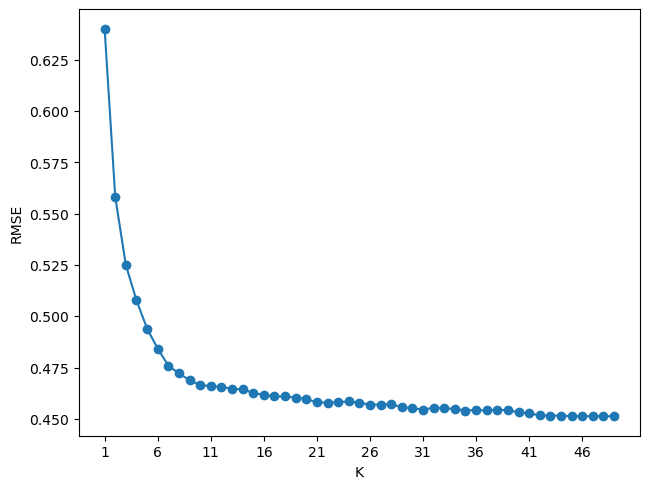

In [8]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,50, 5)])
plt.tight_layout()
plt.xlabel("K")
plt.ylabel("RMSE")

In [20]:
xwoba_model = KNeighborsRegressor(n_neighbors = 11)
xwoba_model.fit(X,Y)

KNeighborsRegressor(n_neighbors=11)

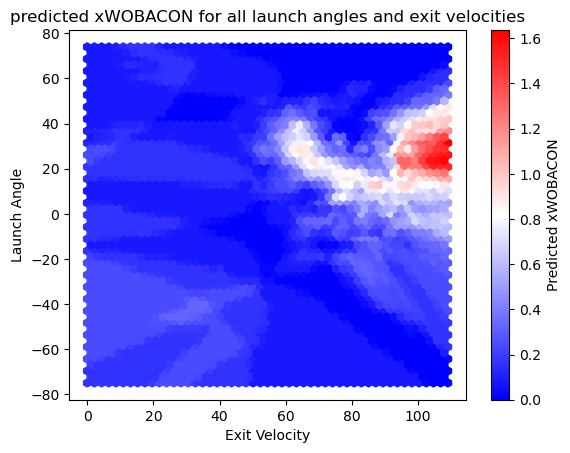

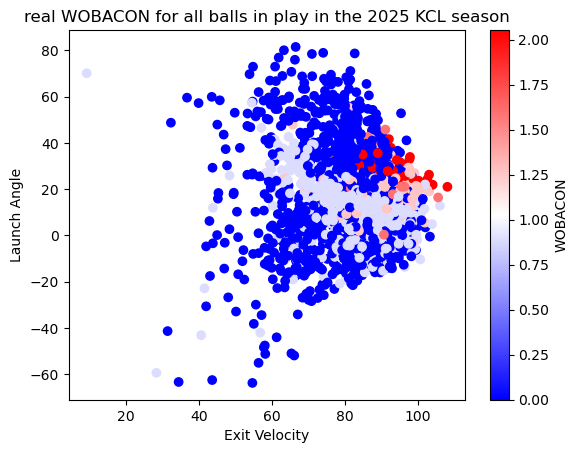

1.7639090909090909

In [21]:
from itertools import product

exit_speeds = range(0,110,1)
launch_angles = range(-75,75,1)
combinations = list(product(exit_speeds, launch_angles))

sim_data = pd.DataFrame(combinations, columns = ['ExitSpeed', 'Angle'])
sim_data['predictedRunValue'] = xwoba_model.predict(sim_data)

X_sim = sim_data['ExitSpeed']
Y_sim = sim_data['Angle']
Z_sim = sim_data['predictedRunValue']

plt.hexbin(X_sim,Y_sim,C = Z_sim, gridsize=50, cmap = 'bwr')
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(label = "Predicted xWOBACON")
plt.title("predicted xWOBACON for all launch angles and exit velocities")
plt.show()

X_real = Contact_Data['ExitSpeed']
Y_real = Contact_Data['Angle']
Z_real = Contact_Data['RunValue']

plt.scatter(X_real,Y_real, c = Z_real, cmap = 'bwr', alpha = 1)
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(label = "WOBACON")
plt.title("real WOBACON for all balls in play in the 2025 KCL season")
plt.show()
max(Z_sim)

In [22]:
Contact_Data.loc[:,'Preds'] = xwoba_model.predict(Contact_Data[['ExitSpeed', 'Angle']])

outcomesData = pd.DataFrame(Contact_Data.groupby('PlayResult')['Preds'].mean().reset_index())

outcomesData

,PlayResult,Preds
0,Double,0.759355
1,Error,0.280502
2,FieldersChoice,0.259074
3,HomeRun,0.935472
4,Out,0.262555
5,Sacrifice,0.304984
6,Single,0.603482
7,Triple,0.729493


In [23]:
def event_predict(event):
    if(not pd.isna(event['ExitSpeed']) and not pd.isna(event['Angle']) and event['PitchCall'] == "InPlay"):
        return xwoba_model.predict([[event['ExitSpeed'], event['Angle']]])[0]
    elif(event['KorBB'] == "Strikeout"):
        return 0
    elif(event['KorBB'] == "Walk"):
        return .695
    elif((pd.isna(event['ExitSpeed']) or pd.isna(event['Angle'])) and event['PitchCall'] == "InPlay"):
        return outcomesData.loc[outcomesData['PlayResult'] == event['PlayResult'], 'Preds'].values[0]

In [24]:
data['xWOBA'] = data.apply(event_predict, axis = 1)
data['xWOBA']
playData = data[['PitchUUID', 'xWOBA']]
playData.to_csv("/Users/noahlippman/Documents/xWOBAFolder/Pitch_By_Pitch_xWOBA.csv")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserW

Lets now calculate each individual player's xWOBA

In [25]:
hitters = data['Batter'].unique()
hitterxWOBADict = {}
hitterWOBADict = {}
hitterPA = {}
for hitter in hitters:
    hitter_data = data[data['Batter'] == hitter]
    hitter_data = hitter_data[hitter_data['PlayResult'].notna()]
    wOBA = hitter_data['RunValue'].mean()
    xWOBA = hitter_data['xWOBA'].mean()
    hitterWOBADict[hitter] = round(wOBA, 3)
    hitterxWOBADict[hitter] = round(xWOBA,3)
    hitterPA[hitter] = len(hitter_data)
    
hitters_data = pd.DataFrame(hitters, columns = ['Batter'])
hitters_data['xWOBA'] = hitters_data['Batter'].map(hitterxWOBADict)
hitters_data['wOBA'] = hitters_data['Batter'].map(hitterWOBADict)
hitters_data['PA'] = hitters_data['Batter'].map(hitterPA)
hitters_data['wOBA - xWOBA'] = hitters_data['wOBA'] - hitters_data['xWOBA']
hitters_data = hitters_data.sort_values(by = 'xWOBA', ascending = False)
hitters_data['Rank'] = range(len(hitters_data['Batter']))
hitters_data['Percentile'] = (len(hitters_data['xWOBA']) - hitters_data['Rank'])/len(hitters_data) * 100
hitters_data.drop("Rank", inplace = True, axis = 1)
#hitters_data.to_csv("/Users/noahlippman/Documents/xWOBAFolder/Hitter_XWOBA.csv")
hitters_data[hitters_data['PA'] > 27].sort_values(by = 'xWOBA', ascending = False)[['Batter','xWOBA']]

,Batter,xWOBA
29,Kaileb Hackman,0.491
8,Lawson Alwan,0.482
41,Ryan Theile,0.477
7,Jaxson Grubbs,0.477
30,Cody Delfavero,0.440
1,Chase Peterson,0.439
26,Tyler Pippin,0.429
9,Taylor Vorhees,0.427
44,Zayn Giles,0.426
68,Brayden Zilis,0.415


In [26]:
hitters_data.to_csv('/Users/noahlippman/Documents/Kernelytics/xWOBA_Data.csv')

In [27]:
def x_zone(cord):
    if(cord < 1 and cord >= .3333):
        return 1
    elif(cord < .3333 and cord >= -.3333):
        return 2
    elif(cord < -.3333 and cord >= -1):
        return 3
    
def y_zone(cord):
    if(cord > 1.5 and cord <= 2.17):
        return 1
    elif(cord > 2.17 and cord <= 2.83):
        return 2
    elif(cord > 2.83 and cord <= 3.5):
        return 3

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/1758926176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/1758926176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/1758926176.py:5: SettingWithCopyWarning: 
A value is trying to be set on a

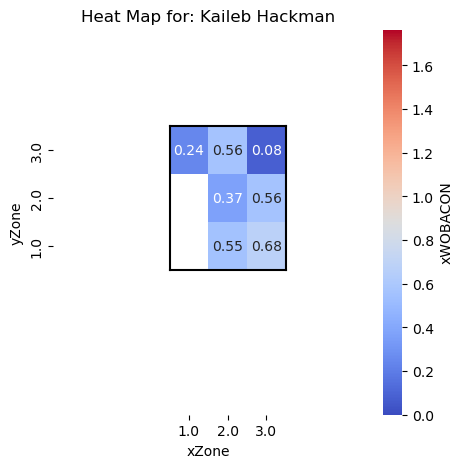

xZone,1.0,2.0,3.0
yZone,,,
1.0,NaN,0.554758,0.678873
2.0,NaN,0.366818,0.561210
3.0,0.241364,0.559218,0.080455


In [28]:
def heat_map_hitter(batter_name):
    heat_data = Contact_Data[Contact_Data['Batter'] == batter_name]
    heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
    heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
    heat_data['xWOBACON'] = (xwoba_model.predict(heat_data[['ExitSpeed', 'Angle']]))

    heat_pivot = pd.pivot_table(data = heat_data,
                                values = "xWOBACON",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'xWOBACON'}, vmin = 0, vmax = max(Z_sim))
    #plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + batter_name)
    plt.show()
    return heat_pivot
heat_map_hitter("Kaileb Hackman")

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/2085794104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/2085794104.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/2085794104.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

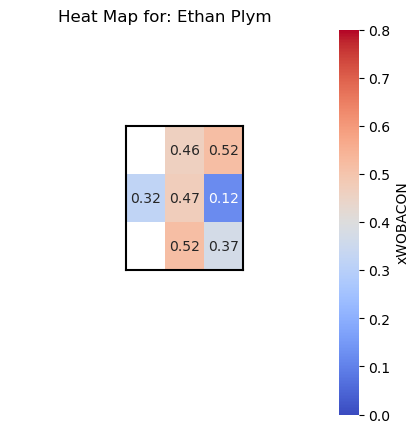

xZone,1,2,3
yZone,,,
1,NaN,0.516636,0.370091
2,0.321818,0.471205,0.120682
3,NaN,0.461909,0.516636


In [29]:
def heat_map_pitcher(pitcher_name, pitch_type = None):
    if pitch_type == None:
        heat_data = Contact_Data[Contact_Data['Pitcher'] == pitcher_name]
    else:
        heat_data = Contact_Data[(Contact_Data['Pitcher'] == pitcher_name) & (Contact_Data['TaggedPitchType'] == pitch_type)]

    heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
    heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
    heat_data['xWOBACON'] = (xwoba_model.predict(heat_data[['ExitSpeed', 'Angle']]))

    heat_pivot = pd.pivot_table(data = heat_data,
                                values = "xWOBACON",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'xWOBACON'}, vmin = 0, vmax = .8)
    plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + pitcher_name)
    plt.show()
    return heat_pivot

heat_map_pitcher("Ethan Plym", "Fastball")

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/170634927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whiff_data['xZone'] = whiff_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_2088/170634927.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whiff_data['yZone'] = whiff_data['PlateLocHeight'].map(y_zone)


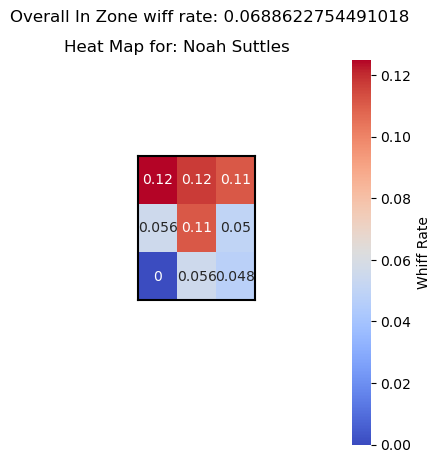

xZone,1.0,2.0,3.0
yZone,,,
1.0,0.000000,0.055556,0.047619
2.0,0.055556,0.111111,0.050000
3.0,0.125000,0.117647,0.111111


In [30]:
def whiff_map_pitcher(pitcher_name, pitch_type = None):
    if pitch_type == None:
        whiff_data = data[data['Pitcher'] == pitcher_name]
    else:
        whiff_data = data[(data['Pitcher'] == pitcher_name) & (data['TaggedPitchType'] == pitch_type)]

    whiff_data['xZone'] = whiff_data['PlateLocSide'].map(x_zone)
    whiff_data['yZone'] = whiff_data['PlateLocHeight'].map(y_zone)

    heat_pivot = pd.pivot_table(data = whiff_data,
                                values = "Whiff",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'Whiff Rate'})
    plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + pitcher_name)
    plt.suptitle("Overall In Zone wiff rate: " + str(whiff_data['Whiff'].mean()))
    plt.show()
    return heat_pivot

whiff_map_pitcher("Noah Suttles")